# Swithching Power e Conduction Power (Testing)

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def poly_energy(current, params=[1,1,1,1]):
    
    ret = np.zeros(current.size)
    n_p = len(params) - 1
    
    for c, p in enumerate(params):
        # print('p', p)
        # print('n_p - c', n_p - c)
        ret += p * current ** (n_p - c)
        
    return ret


def detectCommutation(y):
    y1 = y[:-1]
    y2 = y[1:]
    
    diff = y2 - y1
    
    return y1, y2, diff


def tableSwitchingLosses3(
    switch_s1, switch_s2, current, duration, 
    eon_params1=[1, 1, 1, 1], eoff_params1=[1, 1, 1, 1], erec_params1=[1, 1, 1, 1],
    eon_params2=[1, 1, 1, 1], eoff_params2=[1, 1, 1, 1], erec_params2=[1, 1, 1, 1]):
    '''
        Table with Switching Losses for TDD NPC 3-Levels.
        Curves:
            * eon_params1, eoff_params1 and erec_params1: IGBT1/DIODE5
            * eon_params2, eoff_params2 and erec_params2: IGBT2/DIODE1
        Based in a Semikron Manual, SKiM301MLI12E4
    '''
    
    switch_s1 = np.array(switch_s1)
    switch_s2 = np.array(switch_s2)
    
    current = np.array(current)
    
    _, _, commut1 = detectCommutation(switch_s1)
    _, _, commut2 = detectCommutation(switch_s2)
    
    stateA = np.zeros(commut1.size)
    stateB = np.zeros(commut1.size)
    stateC = np.zeros(commut1.size)
    stateD = np.zeros(commut1.size)
    
    stateA[commut1 == 1] = 1
    stateB[commut1 == -1] = 1
    stateC[commut2 == -1] = 1
    stateD[commut2 == 1] = 1
    
    current0 = current[1:]
    
    current_pos = current0 >= 0
    current_neg = current0 < 0
    
    stateA_cur_pos = stateA * current_pos
    stateA_cur_neg = stateA * current_neg
        
    stateB_cur_pos = stateB * current_pos
    stateB_cur_neg = stateB * current_neg
    
    stateC_cur_pos = stateC * current_pos
    stateC_cur_neg = stateC * current_neg
    
    stateD_cur_pos = stateD * current_pos
    stateD_cur_neg = stateD * current_neg

    # For 'S1'
    s1_eon  = poly_energy(stateA_cur_pos, params=eon_params1)
    s1_eoff = poly_energy(stateB_cur_pos, params=eoff_params1)
    
    # For 'S2'
    s2_eon  = poly_energy(stateD_cur_pos, params=eon_params2)
    s2_eoff = poly_energy(stateC_cur_pos, params=eoff_params2)
    
    # For 'S3'
    s3_eon  = poly_energy(stateB_cur_neg, params=eon_params2)
    s3_eoff = poly_energy(stateA_cur_neg, params=eoff_params2)
    
    # For 'S4'
    s4_eon  = poly_energy(stateC_cur_neg, params=eon_params1)
    s4_eoff = poly_energy(stateD_cur_neg, params=eoff_params1)

    ###
    
    # For 'D1'
    d1_rec = poly_energy(stateB_cur_neg, params=erec_params2)
    
    # For 'D4'
    d4_rec = poly_energy(stateD_cur_pos, params=erec_params2)
    
    # For 'D5'
    d5_rec = poly_energy(stateA_cur_pos, params=erec_params1)
    
    # For 'D6'
    d6_rec = poly_energy(stateC_cur_neg, params=erec_params1)
    
    P_sw = {
        'S1': 1/duration * (np.sum(s1_eoff) + np.sum(s1_eon)),
        'S2': 1/duration * (np.sum(s2_eoff) + np.sum(s2_eon)),
        'S3': 1/duration * (np.sum(s3_eoff) + np.sum(s3_eon)),
        'S4': 1/duration * (np.sum(s4_eoff) + np.sum(s4_eon)),
        
        'D1': 1/duration * (np.sum(d1_rec)),
        'D4': 1/duration * (np.sum(d4_rec)),
        
        'D5': 1/duration * (np.sum(d5_rec)),
        'D6': 1/duration * (np.sum(d6_rec))}
    
    return P_sw, ((stateA, stateB, stateC, stateD),
                  (current_pos, current_neg),
                  ((stateA_cur_pos, stateA_cur_neg),
                   (stateB_cur_pos, stateB_cur_neg),
                   (stateC_cur_pos, stateC_cur_neg),
                   (stateD_cur_pos, stateD_cur_neg),))

## Testing the Switching Losses
### 1. Testando a detecção de comutação

In [6]:
import numpy as np
import matplotlib.pyplot as plt

y = np.array(list('AABBBBCCBBBAABBAABBBCCCBBBCC'))

index1 = y == 'A'
index2 = y == 'B'
index3 = y == 'C'

s1 = np.zeros(len(y))
s2 = np.zeros(len(y))
s3 = np.zeros(len(y))
s4 = np.zeros(len(y))

s1[index1] = 1
s2[index1] = 1

s2[index2] = 1
s3[index2] = 1

s3[index3] = 1
s4[index3] = 1

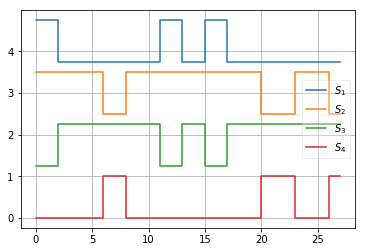

In [5]:
plt.step(range(s1.size), s1+3.75, where='post', label='$S_1$')
plt.step(range(s2.size), s2+2.5, where='post', label='$S_2$')
plt.step(range(s3.size), s3+1.25, where='post', label='$S_3$')
plt.step(range(s4.size), s4, where='post', label='$S_4$')
plt.legend(loc=7, framealpha=.3)
xmin, _ = plt.xlim()
plt.grid()
plt.show()

### 2. Mostrando o sinal simulado para o teste de perdas de comutação

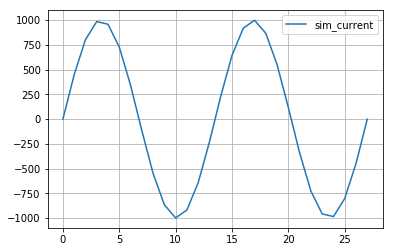

In [147]:
size = y.size

t = np.linspace(0, 2/60, size)
sim_current = 1000*np.sin(2*np.pi*60*t)

plt.plot(sim_current, label='sim_current')
plt.grid(True)
plt.legend()
plt.show()

#### 2.1 Obtendo os parâmetros para as funções

In [148]:
import webbrowser

# webbrowser.open('file:///C:/Users/tiarl/Desktop/Projetos%20GEPOC/' +
#                'Github%20GEPOC/TDD_3-level/input/References/' +
#                'SEMIKRON_DataSheet_SKiM301MLI12E4_23918880.pdf')

In [7]:
# Manual da Semikron (SKiM301MLI12E4)

# Curvas da Fig. 3: Typ. IGBT1 & Diode5 turn-on /-off energy = f (IC)

Ic_pts1   = [150., 200. , 300. , 400., 500., 600.]

eon_pts1  = [ 10.,  14. ,  22.5,  36., 55. ,  70.]
erec_pts1 = [ 15.,  17.5,  24. ,  26., 27.5,  29.]
eoff_pts1 = [ 20.,  25. ,  34. ,  43., 52. ,  61.]

eon_params1  = np.polyfit(Ic_pts1, eon_pts1,  3) / 1e3
eoff_params1 = np.polyfit(Ic_pts1, eoff_pts1, 3) / 1e3
erec_params1 = np.polyfit(Ic_pts1, erec_pts1, 3) / 1e3

# Curvas da Fig. 15: Typ. IGBT2 & Diode1 turn-on /-off energy = f (IC)

Ic_pts2   = [150., 200. , 300. , 400., 500., 600.]

eon_pts2  = [  5.,  7. ,  11. ,  15., 19. ,  23.]
erec_pts2 = [ 15.,  17.,  22.5,  25., 27.5,  31.]
eoff_pts2 = [ 20.,  25. , 36. ,  47., 58. ,  69.]

eon_params2  = np.polyfit(Ic_pts2, eon_pts2,  3) / 1e3
eoff_params2 = np.polyfit(Ic_pts2, eoff_pts2, 3) / 1e3
erec_params2 = np.polyfit(Ic_pts2, erec_pts2, 3) / 1e3

### 3. Parametrizando as curvas $E_{on}$, $E_{off}$ e $E_{rec}$, retiradas de um manual da Semikron para o teste das perdas em comutação com os sinais acima

In [10]:
# Parâmetros de um manual da Semikron (SKiM301MLI12E4)

np.set_printoptions(precision=2)

print('Typ. IGBT1 & Diode5')
print('eon_params:', eon_params1)
print('eoff_params:', eoff_params1)
print('erec_params:', erec_params1)

print('\nTyp. IGBT2 & Diode1')
print('eon_params:', eon_params2)
print('eoff_params:', eoff_params2)
print('erec_params:', erec_params2)

Vo_IGBT = 2.05 # [V]
Ro_IGBT = 3.8*1e-3 # [ohm]

Vo_Diode1 = 2.55 #[V] 
Ro_Diode1 = 3.4*1e-3 # [ohm]

Vo_Diode5 = 2.49 #[V] 
Ro_Diode5 = 3.2 *1e-3 # [ohm]

Typ. IGBT1 & Diode5
eon_params: [-4.27e-10  6.25e-07 -1.34e-04  1.82e-02]
eoff_params: [ 3.73e-11 -4.70e-08  1.09e-04  4.71e-03]
erec_params: [ 1.75e-10 -2.73e-07  1.54e-04 -2.92e-03]

Typ. IGBT2 & Diode1
eon_params: [-9.72e-25  9.23e-22  4.00e-05 -1.00e-03]
eoff_params: [-3.73e-11  4.70e-08  9.14e-05  5.29e-03]
erec_params: [ 1.66e-10 -2.18e-07  1.21e-04  8.47e-04]


In [151]:
P_sw, tmp = tableSwitchingLosses3(
    s1, s2, sim_current, t[-1], 
    eon_params1=eon_params1,eoff_params1=eoff_params1, erec_params1=erec_params1,
    eon_params2=eon_params2,eoff_params2=eoff_params2, erec_params2=erec_params2)

state, current_bool, state_cur = tmp


stateA, stateB, stateC, stateD = state
current_pos, current_neg = current_bool

(stateA_cur_pos, stateA_cur_neg),\
(stateB_cur_pos, stateB_cur_neg),\
(stateC_cur_pos, stateC_cur_neg),\
(stateD_cur_pos, stateD_cur_neg) = state_cur

### 5. Plots que mostram quando a corrente foi detectada como positiva, negativa e o mesmo para a comutação

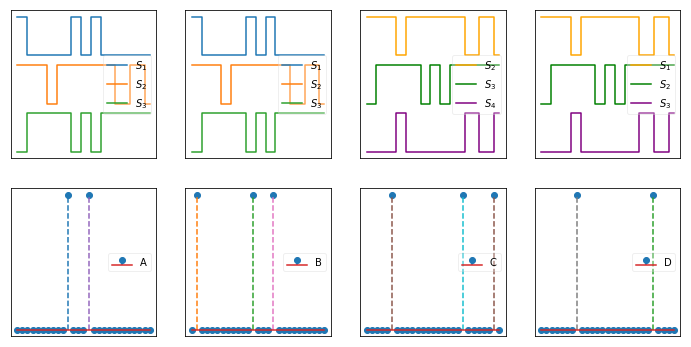

In [152]:
def posChart(ax):
    ax.legend(loc=7, framealpha=.3)
    ax.set_xticks([])
    ax.set_yticks([])

fig, ax = plt.subplots(2, 4, figsize=(12,6))

ax[0][0].step(range(s1.size), s1+3.75, where='post', label='$S_1$')
ax[0][0].step(range(s2.size), s2+2.5, where='post', label='$S_2$')
ax[0][0].step(range(s3.size), s3+1.25, where='post', label='$S_3$')
posChart(ax[0][0])

ax[1][0].stem(range(1, s1.size), stateA, linefmt='--', label='A')
posChart(ax[1][0])

ax[0][1].step(range(s1.size), s1+3.75, where='post', label='$S_1$')
ax[0][1].step(range(s1.size), s2+2.5, where='post', label='$S_2$')
ax[0][1].step(range(s1.size), s3+1.25, where='post', label='$S_3$')
posChart(ax[0][1])

ax[1][1].stem(range(1, s1.size), stateB, linefmt='--', label='B')
posChart(ax[1][1])



ax[0][2].step(range(s1.size), s2+3.75, where='post', label='$S_2$', color='orange')
ax[0][2].step(range(s2.size), s3+2.5, where='post', label='$S_3$', color='green')
ax[0][2].step(range(s3.size), s4+1.25, where='post', label='$S_4$', color='purple')
posChart(ax[0][2])

ax[1][2].stem(range(1, s1.size), stateC, linefmt='--', label='C')
posChart(ax[1][2])

ax[0][3].step(range(s1.size), s2+3.75, where='post', label='$S_1$', color='orange')
ax[0][3].step(range(s1.size), s3+2.5, where='post', label='$S_2$', color='green')
ax[0][3].step(range(s1.size), s4+1.25, where='post', label='$S_3$', color='purple')
posChart(ax[0][3])

ax[1][3].stem(range(1, s1.size), stateD, linefmt='--', label='D')
posChart(ax[1][3])

plt.legend(loc=7, framealpha=.3)
xmin, _ = plt.xlim()
plt.show()

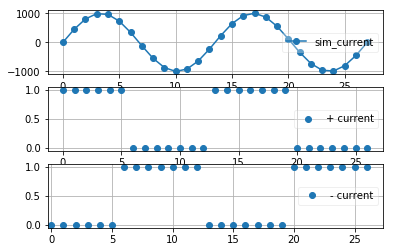

In [153]:
fig, ax = plt.subplots(3, 1)
ax[0].plot(sim_current, '-o', label='sim_current')
ax[0].legend(loc=7, framealpha=.3)
ax[0].grid()
ax[1].plot(current_pos, 'o', label='+ current')
ax[1].legend(loc=7, framealpha=.3)
ax[1].grid()
ax[2].plot(current_neg, 'o', label='- current')
ax[2].legend(loc=7, framealpha=.3)
ax[2].grid()

_, xmax = plt.xlim()
plt.xlim(xmin, xmax)
plt.show()

### 6. Multiplicação dos vetores de comutação e sentido da corrente para para setar o estado em comutação ocorreu e acumular devidamente $E_{on}$,  $E_{off}$ e $E_{rec}$ & Os vetores de corrente para cada estágio em que as comutações ocorreram

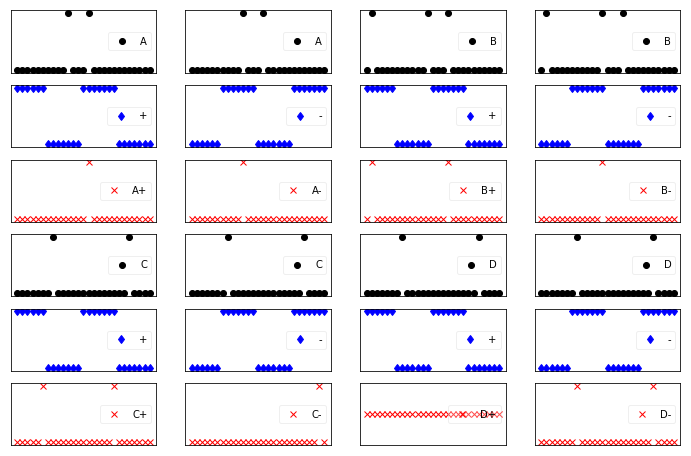

In [154]:
def posChart(ax):
    ax.legend(loc=7, framealpha=.3)
    ax.set_xticks([])
    ax.set_yticks([])

fig, ax = plt.subplots(6, 4, figsize=(12,8))

for axt in [ax[0][0], ax[0][1]]:
    axt.plot(stateA, 'ko ', label='A')
    posChart(axt)

for axt in [ax[0][2], ax[0][3]]:
    axt.plot(stateB, 'ko ', label='B')
    posChart(axt)

for axt in [ax[3][0], ax[3][1]]:
    axt.plot(stateD, 'ko ', label='C')
    posChart(axt)

for axt in [ax[3][2], ax[3][3]]:
    axt.plot(stateD, 'ko ', label='D')
    posChart(axt)

#%%
    
for axt in [ax[1][0], ax[1][2], ax[4][0], ax[4][2]]:
    axt.plot(current_pos, 'bd ', label='+')
    posChart(axt)

for axt in [ax[1][1], ax[1][3], ax[4][1], ax[4][3]]:
    axt.plot(current_neg, 'bd ', label='-')
    posChart(axt)

#%%

for axt, y, label in zip([ax[2][0], ax[2][1], ax[2][2], ax[2][3], ax[5][0], ax[5][1], ax[5][2], ax[5][3]],
                  [stateA_cur_pos, stateA_cur_neg, stateB_cur_pos, stateB_cur_neg, 
                   stateC_cur_pos, stateC_cur_neg, stateD_cur_pos, stateD_cur_neg],
                  ['A+', 'A-', 'B+', 'B-', 'C+', 'C-', 'D+', 'D-']):
    axt.plot(y, 'rx ', label=label)
    posChart(axt)


### 7. Resultado Final das potências dissipadas de cada um dos semicondutores $S_1$, $S_2$, $D_1$ e $D_2$ , em Watts

In [1]:
plt.plot([0], P_sw['S1'], 'o', label='Power Switching (S1)')
plt.plot([1], P_sw['S2'], 'o', label='Power Switching (S2)')
plt.plot([2], P_sw['S3'], 'o', label='Power Switching (S3)')
plt.plot([3], P_sw['S4'], 'o', label='Power Switching (S4)')
plt.grid()
plt.legend()
plt.show()

plt.plot([4], P_sw['D1'], 'o', label='Power Switching (D1)')
plt.plot([5], P_sw['D4'], 'o', label='Power Switching (D4)')
plt.plot([6], P_sw['D5'], 'o', label='Power Switching (D5)')
plt.plot([7], P_sw['D6'], 'o', label='Power Switching (D6)')
plt.grid()
plt.legend()
plt.show()

NameError: name 'plt' is not defined

### Ap. Gráfico com os polinômios gerados para cada equação de energia

In [157]:
i = np.linspace(0, 800, 200)

eon_params  = eon_params2
eoff_params = eoff_params2
erec_params = erec_params2

In [158]:
eon = poly_energy(i, eon_params)
eoff = poly_energy(i, eoff_params)
erec = poly_energy(i, erec_params)

In [159]:
print('eon_params:', eon_params)
print('eoff_params:', eoff_params)
print('erec_params:', erec_params)

eon_params: [-9.71772056e-25  9.22791904e-22  4.00000000e-05 -1.00000000e-03]
eoff_params: [-3.72552150e-11  4.69919915e-08  9.13673504e-05  5.28801923e-03]
erec_params: [ 1.66483192e-10 -2.18114438e-07  1.21076158e-04  8.47057538e-04]


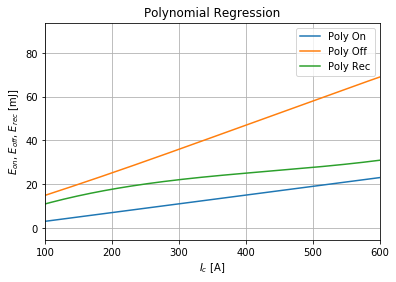

In [160]:
plt.plot(i, eon*1e3, label='Poly On')
plt.plot(i, eoff*1e3, label='Poly Off')
plt.plot(i, erec*1e3, label='Poly Rec')
plt.title('Polynomial Regression') 
plt.xlabel('$I_c$ [A]') 
plt.ylabel('$E_{on}$, $E_{off}$, $E_{rec}$ [mJ]')
plt.grid()
plt.legend()
plt.xlim(100, 600)
plt.show()

## Testing the Conduction Losses

In [25]:
def rmsValue(current):
    '''
    Calculate the RMS value.
    '''
    
    import numpy as np
    
    return np.sqrt(np.sum(np.power(current, 2)) / current.size)

In [26]:
def tableConductionLosses3(switch_s1, switch_s2, current, Vo_IGBT, Vo_Diode, Ro_IGBT, Ro_Diode):
    '''
        Table with Switching Losses for TDD 2-Levels.
    '''
    
    switch_s1 = np.array(switch_s1)
    current = np.array(current)
    
    switch_s2 = np.zeros(switch_s1.size)
    switch_s2 = switch_s1 == 0
    
    pos_current = current >= 0
    neg_current = current < 0
    s1_times_current = switch_s1 * current
    s2_times_current = switch_s2 * current
    current_s1 = np.zeros(current.size)
    current_s1[pos_current] = s1_times_current[pos_current]
    current_d1 = np.zeros(current.size)
    current_d1[neg_current] = -1 * s1_times_current[neg_current]
    current_s2 = np.zeros(current.size)
    current_s2[neg_current] = -1 * s2_times_current[neg_current]
    current_d2 = np.zeros(current.size)
    current_d2[pos_current] = s2_times_current[pos_current]

    s1_cd = Vo_IGBT  * np.mean(current_s1) + Ro_IGBT  * np.power(rmsValue(current_s1), 2) 
    s2_cd = Vo_IGBT  * np.mean(current_s2) + Ro_IGBT  * np.power(rmsValue(current_s2), 2)
    d1_cd = Vo_Diode * np.mean(current_d1) + Ro_Diode * np.power(rmsValue(current_d1), 2)
    d2_cd = Vo_Diode * np.mean(current_d2) + Ro_Diode * np.power(rmsValue(current_d2), 2)
    
    P_cd = {'S1': s1_cd,
            'S2': s2_cd,
            'D1': d1_cd,
            'D2': d2_cd}
    
    return P_cd, ((switch_s1, switch_s2), 
                  (current_s1, current_d1, current_s2, current_d2),
                  (rmsValue(current_s1), rmsValue(current_d1), 
                   rmsValue(current_s2), rmsValue(current_d2)))

### 1. Generating the signals for test

In [33]:
size = 35

t = np.linspace(0, 1/60, size)

np.random.seed(5)

sim_switch_s1  = np.random.randint(0, 2, size=size)
sim_current = 1000*np.sin(2*np.pi*60*t )
Vdc = 800

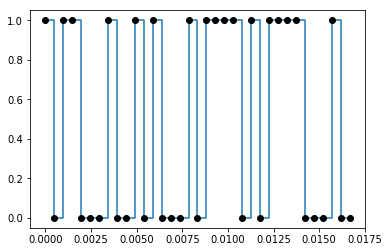

In [34]:
plt.step(t, sim_switch_s1, where='post')
plt.plot(t, sim_switch_s1, 'ko')

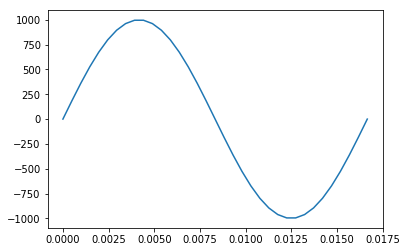

In [35]:
plt.plot(t, sim_current)

In [38]:
P_cd, tmp = tableConductionLosses(sim_switch_s1, sim_current, Vo_IGBT, Vo_Diode, Ro_IGBT, Ro_Diode)

((switch_s1, switch_s2), 
 (current_s1, current_d1, current_s2, current_d2), 
 (current_s1_rms, current_d1_rms, 
  current_s2_rms, current_d2_rms)) = tmp

### 3. Resultado do espelhamento do comando de $S_1$

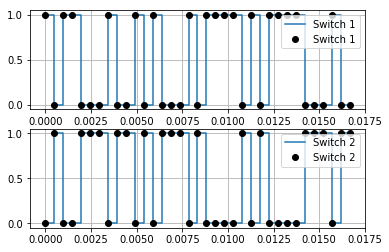

In [39]:
plt.subplot(211)
plt.step(t, switch_s1, label='Switch 1', where='post')
plt.plot(t, switch_s1, 'ko ', label='Switch 1')
plt.legend()
plt.grid()
plt.subplot(212)
plt.step(t, switch_s2, label='Switch 2', where='post')
plt.plot(t, switch_s2, 'ko ', label='Switch 2')
plt.legend()
plt.grid()

### 4. Plots que mostram que os semicondutores estão conduzindo nos momentos certos e no sentido correto da corrente

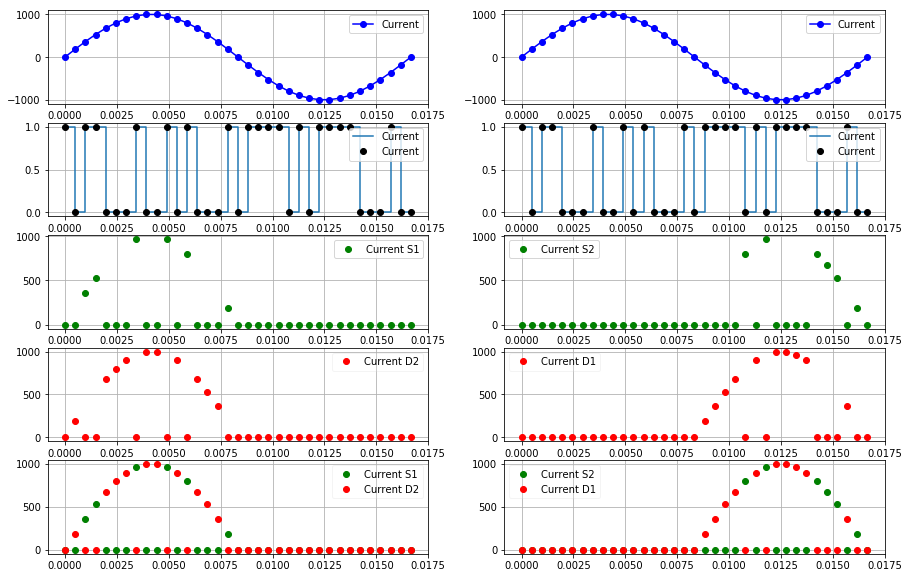

In [40]:
fig, ax = plt.subplots(5,2, figsize=(15, 10))

ax[0][0].plot(t, sim_current, 'bo-', label='Current')
ax[0][0].legend()
ax[0][0].grid()
# plt.subplot(522)
ax[0][1].plot(t, sim_current, 'bo-', label='Current')
ax[0][1].legend()
ax[0][1].grid()

ax[1][0].step(t, switch_s1, label='Current', where='post')
ax[1][0].plot(t, switch_s1, 'ko ', label='Current')
ax[1][0].legend()
ax[1][0].grid()
# plt.subplot(524)
ax[1][1].step(t, switch_s1, label='Current', where='post')
ax[1][1].plot(t, switch_s1, 'ko ', label='Current')
ax[1][1].legend()
ax[1][1].grid()

ax[2][0].plot(t, current_s1, 'go ', label='Current S1')
ax[2][0].legend()
ax[2][0].grid()
# plt.subplot(526)
ax[2][1].plot(t, current_s2, 'go ', label='Current S2')
ax[2][1].legend()
ax[2][1].grid()

ax[3][0].plot(t, current_d2, 'ro ', label='Current D2')
ax[3][0].legend(framealpha=.2)
ax[3][0].grid()
# plt.subplot(528)
ax[3][1].plot(t, current_d1, 'ro ', label='Current D1')
ax[3][1].legend(framealpha=.2)
ax[3][1].grid()

ax[4][0].plot(t, current_s1, 'go ', label='Current S1')
ax[4][0].plot(t, current_d2, 'ro ', label='Current D2')
ax[4][0].legend(framealpha=.2)
ax[4][0].grid()
# plt.subplot(5210)
ax[4][1].plot(t, current_s2, 'go ', label='Current S2')
ax[4][1].plot(t, current_d1, 'ro ', label='Current D1')
ax[4][1].legend(framealpha=.2)
ax[4][1].grid()

### 5. Plot que mostram o valor RMS para cada uma das correntes avaliadas

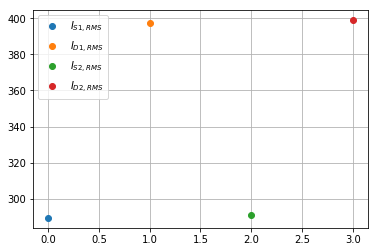

In [41]:
plt.plot([0], current_s1_rms, 'o', label='$I_{S1, RMS}$')
plt.plot([1], current_d1_rms, 'o', label='$I_{D1, RMS}$')
plt.plot([2], current_s2_rms, 'o', label='$I_{S2, RMS}$')
plt.plot([3], current_d2_rms, 'o', label='$I_{D2, RMS}$')
plt.legend()
plt.grid()
plt.show()

### 6. Resultado Final, as perdas em comutação para cada uma dos semicondutores, em Watts

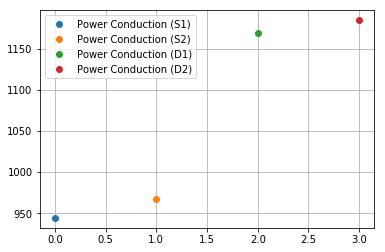

In [44]:
plt.plot([0], P_cd['S1'], 'o', label='Power Conduction (S1)')
plt.plot([1], P_cd['S2'], 'o', label='Power Conduction (S2)')
plt.plot([2], P_cd['D1'], 'o', label='Power Conduction (D1)')
plt.plot([3], P_cd['D2'], 'o', label='Power Conduction (D2)')
plt.grid()
plt.legend()
plt.show()

### Ap. Plot que mostra a condução completa feita por todos os semicondutores cada um em um momento

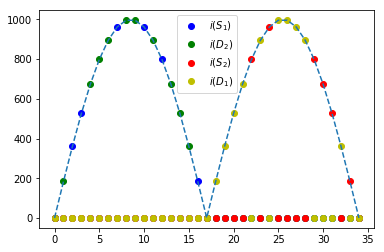

In [43]:
plt.plot(current_s1, 'bo', label='$i(S_1)$')
plt.plot(current_d2, 'go', label='$i(D_2)$')
plt.plot(current_s2, 'ro', label='$i(S_2)$')
plt.plot(current_d1, 'yo', label='$i(D_1)$')
plt.plot(np.abs(sim_current), '--')
plt.legend()
plt.show()